## Imports

In [62]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import os
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import rankdata
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pio.renderers.default = "svg"


## Import data

In [6]:
users = pd.read_csv('article_user.csv')
articles = pd.read_csv('articles.csv')

In [7]:
users

,user_id,article_id,timestamp
0,2bc424123e0a12d29c488bb6e565fe98d0a49b46,e9d06b2bb42bd9970de43beab2d3893534d7a619,1611291180
1,2bc424123e0a12d29c488bb6e565fe98d0a49b46,e98b0d02b16794bc0884a61c4a45746cb9430630,1611290464
2,2bc424123e0a12d29c488bb6e565fe98d0a49b46,05f51c586ada891448ab56d9a5c8adb2a688e2fb,1611406104
3,2bc424123e0a12d29c488bb6e565fe98d0a49b46,91333a3c6d28c9241cbb01678a97699232b79e70,1611531797
4,2bc424123e0a12d29c488bb6e565fe98d0a49b46,30170d08779c54b84170d4cb3b5cbe0462df704a,1611270926
...,...,...,...
520225,a5960b8352e6605d3864bfbf39f9d0cf5a3e1d26,77e2fe5aa1b34a93491af7516ae6e12fc1d37b28,1611517200
520226,a5960b8352e6605d3864bfbf39f9d0cf5a3e1d26,eb0413f63ea5928aa27777494d3878a5bc505842,1611267374
520227,a5960b8352e6605d3864bfbf39f9d0cf5a3e1d26,62161f4a31f82ffedd53d4ac1ee5f554be959442,1611403946
520228,a5960b8352e6605d3864bfbf39f9d0cf5a3e1d26,77e2fe5aa1b34a93491af7516ae6e12fc1d37b28,1611524302


In [8]:
articles

,article_id,headline,url,published_date
0,e9d06b2bb42bd9970de43beab2d3893534d7a619,Defense Department slams brakes on border wall...,https://www.cnn.com/2021/01/21/politics/border...,2021-01-21 21:45:03.000 Z
1,e98b0d02b16794bc0884a61c4a45746cb9430630,Biden's DOJ must confront what to do with outs...,https://www.cnn.com/2021/01/21/politics/donald...,2021-01-22 02:11:02.000 Z
2,05f51c586ada891448ab56d9a5c8adb2a688e2fb,White House wants Democrats to be patient on s...,https://www.cnn.com/2021/01/22/politics/covid-...,2021-01-22 21:53:55.000 Z
3,91333a3c6d28c9241cbb01678a97699232b79e70,The Supreme Court's run out of excuses to avoi...,https://www.cnn.com/2021/01/24/politics/suprem...,2021-01-24 18:42:26.000 Z
4,30170d08779c54b84170d4cb3b5cbe0462df704a,Evidence shows Capitol rioters brutally attack...,https://www.cnn.com/2021/01/21/politics/capito...,2021-01-21 12:45:30.000 Z
...,...,...,...,...
1450,7fb19aeffd8ccef0ba584af55c0e7f30b3fcfede,F1 driver Nikita Mazepin apologizes for 'inapp...,https://www.cnn.com/2020/12/10/motorsport/niki...,2020-12-10 14:34:42.000 Z
1451,cf65267c74211e41ab109cf052a2643fff3030d8,James Meredith: I am George Floyd,https://www.cnn.com/2020/06/18/opinions/i-am-g...,2020-12-20 00:46:27.000 Z
1452,335a7889373bd79aac32ec379e08494dc7786700,"Microsoft, Oracle and other tech giants team u...",https://www.cnn.com/2021/01/16/tech/coronaviru...,2021-01-17 22:14:28.000 Z
1453,93b39b5ad4db94bd002e56fef8617c3713862fbc,Science's most fascinating and awe-inspiring d...,https://www.cnn.com/2020/12/29/world/science-d...,2020-12-29 13:29:11.000 Z


## Explore Data

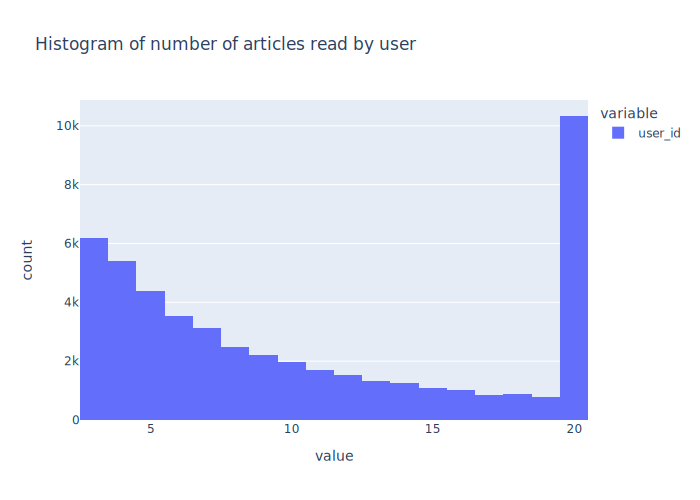

In [53]:
px.histogram(users.user_id.value_counts(), title='Histogram of number of articles read by user')

11k users have read 20 articles, We have at least 3 articles read per user.

We probably want to see the predictions behavior for the 20-article users vs the 3-article users

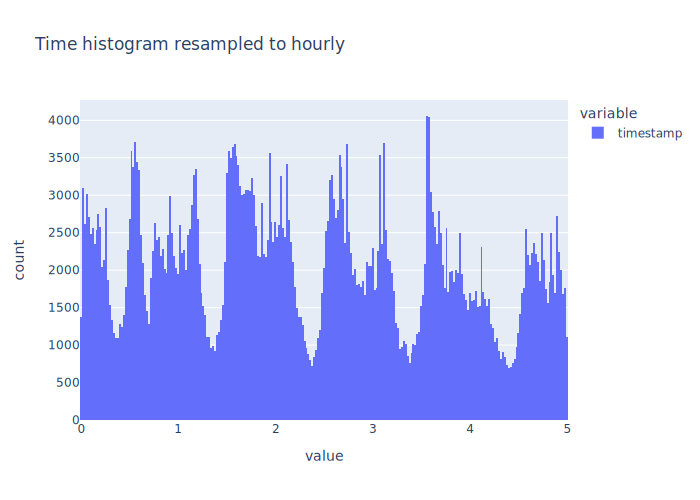

In [10]:
px.histogram((users.timestamp - users.timestamp.min())/(60*60*24), title='Time histogram resampled to hourly')

No data gaps in the timeline of the data - Can use all data as training set without concerns

N of articles has a periodic daily behavior. Probably users read less news at night?

In [11]:
users.duplicated().any()

True

In [12]:
users.drop_duplicates(inplace=True)

Remove duplicated data in users

In [13]:
users.isna().sum().sum()

0

No Nans in the data and duplicates dropped

In [14]:
list(users.article_id.unique()) == list(articles.article_id)

True

I have a headline for every article in the users table

In [54]:
px.histogram(pd.to_datetime(articles['published_date'], format='%Y-%m-%d %H:%M:%S')title='Histogram of published date of articles')

SyntaxError: invalid syntax (<ipython-input-54-664810797c61>, line 1)

Most articles read are from 2021, in first approximation I can recommend any article on this set

Extremely likely the recommended article will be a new article

## Recommending Options

###  Content based recommendation

I will only use Content based recommendations, the next best approach would be collaborative filtering not implemented here
<br>
The only feature I have to describe an article is the headline 
<br>
I can suggest an articles that is similar to the articles the user have read in the past
<br>
I need a metric to indicate how similar 2 articles are: I will use a vector representation for the headline and a similarity metric for two vectors
<br>
The 2 vector approaches to explore are **TfIdf and Bert**

## Implementation of TfIdf and Bert models

In [18]:
class Recommender():
    def __init__(self, articles):
        self.articles = articles
        self.cosine_sim = None
        self.top5 = None
    def train_tfidf(self, train):
        tfidf = TfidfVectorizer(stop_words='english')
        tfidf_matrix = tfidf.fit_transform(train.headline)
        self.cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
    def train_bert(self, train):
        model = SentenceTransformer('bert-base-nli-mean-tokens')
        sentence_embeddings = model.encode(train.headline)
        self.cosine_sim =  cosine_similarity(sentence_embeddings,sentence_embeddings)
    def load_top5_articles(self, users):
        top5_id= users.article_id.value_counts()[0:5]
        top5_art =pd.merge(top5_id,self.articles,left_index=True,right_on ='article_id')
        self.top5 = top5_art['headline']
    def recommend_top5(self, user):
        """Alwasys recommends the top5 articles across all data"""
        return self.top5
    def recommend(self, user ,users):
        """Recommend articles for user"""
        prev_articles = self.prev_articlesid(user,users)
        similar = self.similar5( prev_articles)
        return self.id2headline(similar)
    def prev_articlesid(self, user,users):
        """all previous articles for user in users df"""
        return  users[users.user_id==user]['article_id']
    def similar_vector(self, prev_articles):
        """vector of lenght number of headlines representing how similar a headine is to previous articles"""
        idxs = self.articles[self.articles['article_id'].isin(prev_articles)  ].index
        vectors = self.cosine_sim[idxs]
        vector = vectors.mean(axis=0) # mean across all previous articles, in a next level model most recent articles can have more weight
        return vector
    def similar5(self,prev_articles ):
        vector = self.similar_vector(prev_articles)
        ranks = len(self.articles)- rankdata(vector) # inverting  so rank 0 is the first recommendation
        idxs = ranks.argsort()[:5]
        return articles.iloc[idxs]['article_id']
        
    def id2headline(self, article_ids):
        return self.articles[self.articles['article_id'].isin(article_ids)]['headline']
    def rank_article(self, user,users,  articleid):
        """Returns the rank in the recommendation system for the article"""
        prev_articles = self.prev_articlesid( user,users)
        vector = self.similar_vector( prev_articles)
        ranks = len(self.articles)- rankdata(vector) # inverting  so rank 0 is the first recommendation
        idx = self.articles[self.articles.article_id == articleid ].index[0]
        return ranks[idx]


The class recommender provides methods for recommendations using two models, they both use vector representations for the headlines 


## Divide the users dataset into test and train
Test is the composed of the last article for every user and train is the rest of the data

In [19]:
test = users.loc[users.groupby("user_id")["timestamp"].idxmin()]
train = pd.concat([users, test]).drop_duplicates(keep=False)
test.reset_index(drop=True,inplace=True)
train.reset_index(drop=True,inplace=True)

In [20]:
len(train) +len(test) , len(users)

(520172, 520172)

Trainning the system with the headlines and the tfidf model

In [21]:
recommender = Recommender(articles)

In [22]:
%%time
recommender.train_tfidf(articles)

Wall time: 15.7 ms


In [23]:
recommender.cosine_sim.shape, len(articles)

((1455, 1455), 1455)

This the similarity matrix for N of headlines 

In [24]:
user = test.user_id.iloc[0]
user

'0002604d5804123dedb91819acbc93f888c54b8e'

## Recommender method that suggest top 5 articles for a given user with the tdidf model

In [25]:
recommender.recommend(user,test)

106    Meet Ella Emhoff, the US presidential inaugura...
116    11 ways kids can take part in the presidential...
118             How a US presidential inauguration works
140    American fashion designers take center stage a...
440    Succession: Presidential and Vice Presidential...
Name: headline, dtype: object

## Recommender method that suggest top 5 articles for a given user with the bert model

In [26]:
%%time
recommender.train_bert(articles)

Wall time: 50.8 s


In [27]:
recommender.recommend(user,test)

106     Meet Ella Emhoff, the US presidential inaugura...
118              How a US presidential inauguration works
140     American fashion designers take center stage a...
572     The Howard University marching band escorted V...
1152    Biden's inaugural committee hosting 'virtual p...
Name: headline, dtype: object

## Recommender method that suggest top 5 most popular articles regardless of the user

In [28]:
recommender.load_top5_articles(train)

In [29]:
recommender.recommend_top5(user)

76    McConnell privately says he wants Trump gone a...
41    This town powered America for decades. What do...
40            The face mask that could end the pandemic
96     Larry King, legendary talk show host, dies at 87
12    Bidens quickly fire White House chief usher in...
Name: headline, dtype: object

####  reasonable approach is to use the naive top 5 most popular articles when there is no previous data for the user

## Models explanation

##### Tfidf revision 

In TfIdf if t is the term and h is the headline, then:
    
tf(t,h) = count of t in d / number of words in h
<br>
df(t) = occurrence of t in all headlines
<br>
idf(t) = log(N/ df(t))

And Tfidf is defined as:

tf-idf(t, d) = tf(t, d) * idf(t)

*So TfIdf is high for terms that are frequent in the headline and is penalized if the term is common across multiple headlines*


#### Implementation of TfidfVectorizer with sklearn

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [31]:
tfidf = TfidfVectorizer(stop_words='english')

In [32]:
%%time
tfidf_matrix = tfidf.fit_transform(articles.headline)

Wall time: 15.7 ms


#### Confirming the TfidfVectorizer matrix is consistent with our expectations

In [33]:
tfidf_matrix

<1455x4520 sparse matrix of type '<class 'numpy.float64'>'
	with 11146 stored elements in Compressed Sparse Row format>

The shape of the matrix is len(articles) by Number of terms across all headlines

In [34]:
df_idf = pd.DataFrame(tfidf.idf_, index=tfidf.get_feature_names(),columns=["idf_weights"]) 
df_idf.sort_values(by=['idf_weights'], ascending=False)

,idf_weights
kremlin,7.590301
monument,7.590301
moon,7.590301
moschino,7.590301
moscow,7.590301
...,...
19,3.914000
capitol,3.829101
covid,3.698481
biden,2.970242


The idf part of Tfidf is working as expected
<br>
Kremlin, monument are very unique words across all headlines, while trump, biden, ... are not

In [35]:
# Sparse matrix to dense, adding the terms back and pringing not zeros
df_tfidf = pd.DataFrame(tfidf_matrix.todense()[0].T, index=tfidf.get_feature_names(),columns=["tfidf"]) 
df_tfidf[df_tfidf.tfidf != 0].sort_values(by='tfidf')

,tfidf
biden,0.160726
defense,0.305429
wall,0.305429
border,0.318479
department,0.323636
order,0.323636
slams,0.373219
brakes,0.410726
reviews,0.410726


Tfidf is working as expected for the first headline
<br>
"on, as, it, etc" are scrapped because of the *stop_words='english'* option used to build the matrix
<br>
There are not repeating words in the tittle then Tfidf is dominated by idf which is low for "Biden" (common word)

#### Implementation of Similarity Metric

For the similarity metric we can use the cosine function
<br>
Each headline is represented by a vector in our tfidf matrix and the similarity between two healines will be the cosine between the vectors

In [36]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim.shape

(1455, 1455)

cosine_sim shape is Nheadlines x Nheadlines

##### Bert representation 

BERT stands for Bidirectional Encoder Representations from Transformers it is a pre-train model arquitecture developed on 2018 (https://arxiv.org/abs/1810.04805)

Here I use the implemenation in the SentenceTransformers library

## Model evaluation

Approach: The recomendation model is user driven, so I have to  evaluate on every user: 

**test set**: the last article read by every user  

**train set**: the rest of the dataset, the data provides at least 3 articles for every user so train will have at least 2 articles per user


**metric** : ranking for the test article - A number from 0 to total number of articles (1455) indicating how the model will rank this article. 0 being the first article to recommend and 1455 the last article to recommend

** Potential improvements to the evaulation:**

Crossvalidation test will give more reliable results

Deploying to prod the model and AB test would be the best possible evalution of the model





### Calculate the Ranks for the TfIdf  model for the users in the test set

In [37]:
%%time
recommender.train_bert(articles)

Wall time: 50.7 s


In [38]:
%%time
bert_ranks = test.apply(lambda x: recommender.rank_article( x.user_id, train,  x.article_id) , axis=1 )

Wall time: 21min 39s


### Calculate the Ranks for the Bert model for the users in the test set

In [39]:
%%time
recommender.train_tfidf(articles)

Wall time: 31.3 ms


In [40]:
%%time
tfidf_ranks = test.apply(lambda x: recommender.rank_article( x.user_id, train,  x.article_id) , axis=1 )

Wall time: 21min 39s


#### Calculate the ranks takes ~20 mins in my box

In [42]:
test_ranks = test.copy()
test_ranks['NarticlesinTrain'] =  train.groupby(['user_id'])['article_id'].count().reset_index()['article_id']
test_ranks['bert'] = bert_ranks
test_ranks['tfidf'] = tfidf_ranks
test_ranks['NarticlesinTrain'] = test_ranks.NarticlesinTrain.astype('float')
test_ranks

,user_id,article_id,timestamp,NarticlesinTrain,bert,tfidf
0,0002604d5804123dedb91819acbc93f888c54b8e,f09985cd3473960ea8c464e24ade4de4a8c1f8f0,1611214049,5.0,880.0,141.0
1,0003728d0245028f76f7a655241a07181d1be815,fc7b3420a3eec9b26efa0e83b2786f44a6cae198,1611146426,19.0,1359.0,1175.5
2,000430b60d8f1dfbc40f387c57a83989f9fa93a9,14f75c96e5652ca34b2e1c8e6eadbc5e2d7f9a36,1611104507,13.0,139.0,76.0
3,0004c5445d969cabdb55c8fa69f3fd5212723032,f4bfbf1c7b245390cf57aab2445102d6d7573825,1611276694,2.0,1271.0,844.5
4,0005c0d4d9f01b62578a4987a7ec4fcd95fada4a,414837fd482671f85cc32524de3116f690723be8,1611378746,3.0,618.0,85.0
...,...,...,...,...,...,...
49995,fffb5887fbd6f820ca50ce3787fdd8bd2c87a3c4,33a5e4aac5a0295c7d3ef98179bda0e6ef724f09,1611240159,8.0,410.0,10.0
49996,fffbacf805a9436e177d6b243883fc2c7832ab5e,0b901f02b68e26eb9e8bbc0fa0c54d54cb81c312,1611164319,8.0,685.0,367.0
49997,fffca37521dbe342b103e4c05a70522291240f1e,56653a4b9ba87a90da98f10050455adb18920425,1611110275,19.0,28.0,422.0
49998,ffff1ae26738234ebd6ccfdb2fa197a409f0e65b,0cd967da0300dabedf4db6f7afe6313ede72b109,1611162819,6.0,518.0,579.0


testranks is a Dataframe with test data + Nof articles in the train set + Ranks for the test article in both models

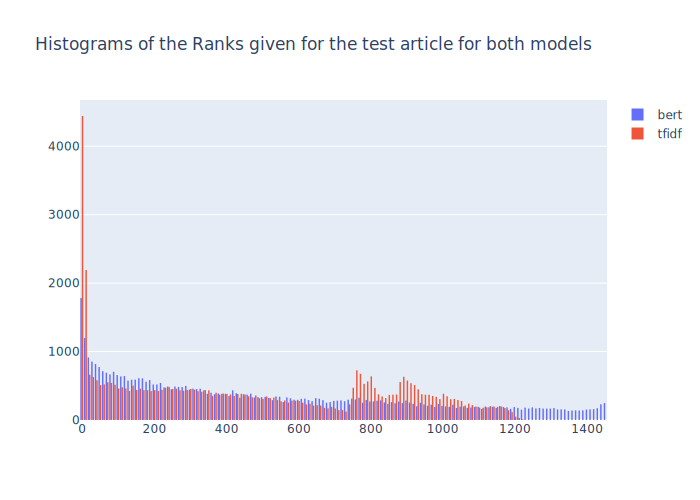

In [43]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=test_ranks['bert'],name='bert'))
fig.add_trace(go.Histogram(x=test_ranks['tfidf'],name = 'tfidf'))
fig.update_layout(title = 'Histograms of the Ranks given for the test article for both models')

In this graph each bar represents the number of times that an article got ranked at that value

The best model will rank most of these articles near zero. A few observations:
    1. The TfIdf model is better sugessting the top 10 articles. 
    2. The Bert model is better in the 10-700 range
    3. Bert is monotonically decreasing to lower ranks, this what is expected for the model as we want the model to give a high number of good predictions and low number of bad ones
    4. TfIdf is not monotonic with some more peak at around 800 -1000, this is unexpected

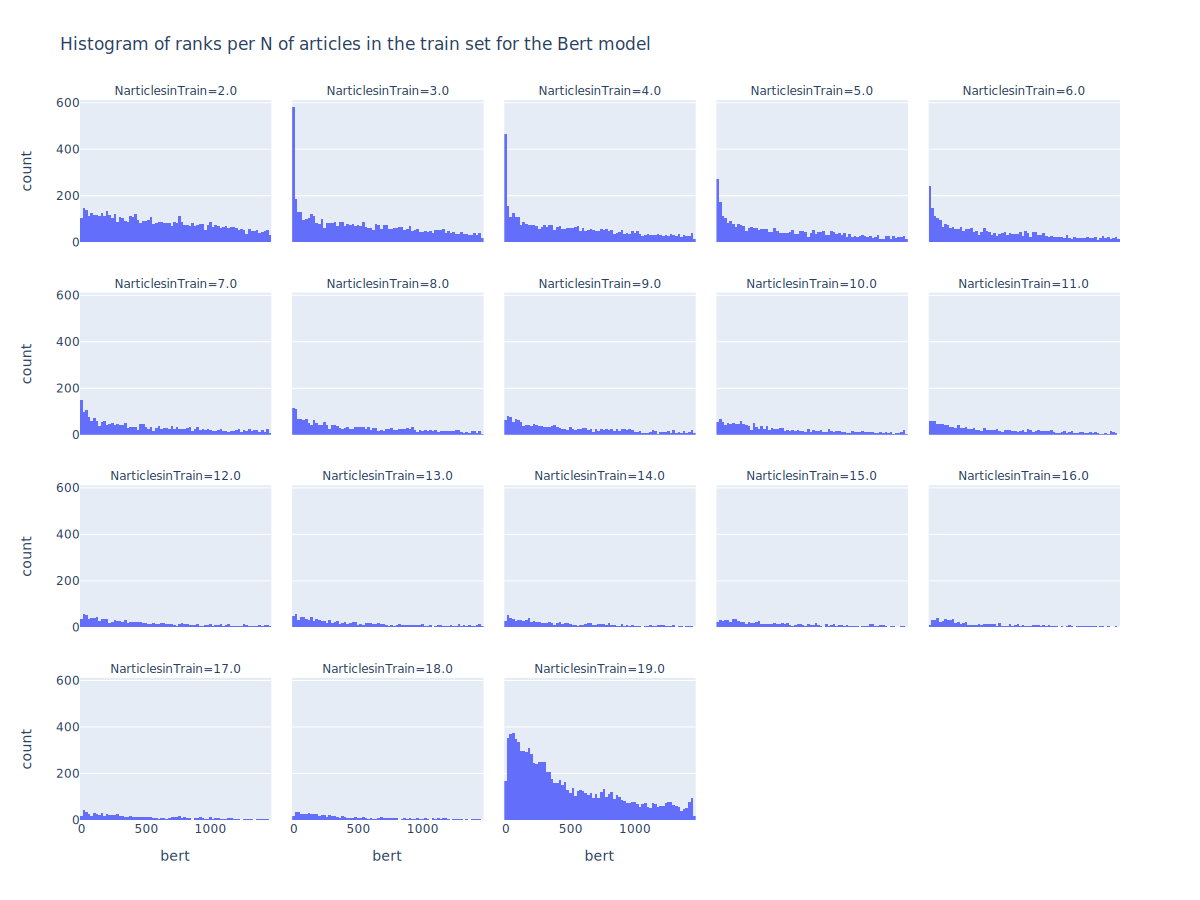

In [64]:
px.histogram(test_ranks.sort_values(['NarticlesinTrain']),x='bert',facet_col='NarticlesinTrain',width =1200, height=900, facet_col_wrap=5,title ="Histogram of ranks per N of articles in the train set for the Bert model")


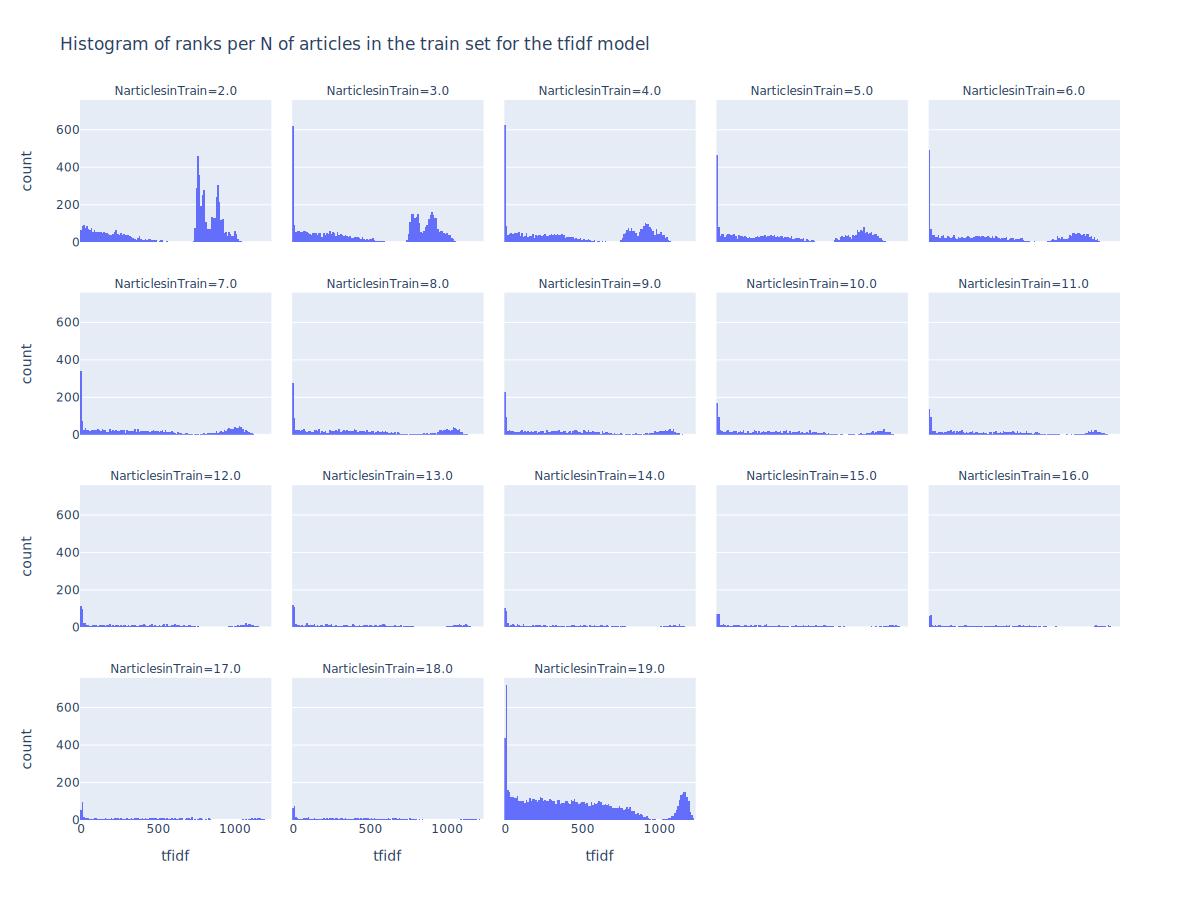

In [68]:
px.histogram(test_ranks.sort_values(['NarticlesinTrain']),x='tfidf',facet_col='NarticlesinTrain',width =1200, height=900, facet_col_wrap=5,title ="Histogram of ranks per N of articles in the train set for the tfidf model")


In the previous plots we partitionate the ranking hisotograms by the Number of articles in the train data for the user:
    1. The 800-1000 unexpected bump in the tfidf model is coming from the users with very low data NarticlesTrain = 2 or 3, this indicates that tfidf does a bad job with very limited data. Bert does not have that issue, even with very low data (2,3,4) the histogram is sill monotonic
    2. For Bert the histogram seem to increase in slop with larger NarticlesinTrain, meaning that the prediction power does benefit from more data, which is not the case for TfIdf
    3. TfIdf shows the 0-10 range peak regardless of the NarticlesinTrain
    
**Bert is probably going to generalize better in both extremes, less data and more data per user**
    

### Finally let's check why TfIdf is so good at predicting top articles

In [46]:
def Isrecommendedseen(user, train, articleid):
    """Checks if articleid is part of the articles in train for user"""
    prev = recommender.prev_articlesid( user, train).tolist()
    return articleid in prev

In [47]:
%%time
recommender.train_tfidf(articles)

Wall time: 31.3 ms


Make sure we have tfidf as our model

In [48]:
top_ranks_tfidf = test_ranks[test_ranks.tfidf <6] # the test article was in the top5 recommendations
top_ranks_tfidf_seen = top_ranks_tfidf.apply(lambda x: Isrecommendedseen(x.user_id,train,x.article_id) , axis=1 )

1. Select users in the Recall 5 set: these are the users for which the test article was in the top 5 recommendations
2. Check if users in Recall 5 set are rereading an article

In [49]:
%%time
recommender.train_bert(articles)

Wall time: 52.7 s


In [50]:
top_ranks_bert = test_ranks[test_ranks.bert <6] # the test article was in the top5 recommendations
top_ranks_bert_seen = top_ranks_bert.apply(lambda x: Isrecommendedseen(x.user_id,train,x.article_id) , axis=1 )

In [51]:
print("Recall 5: Number of users for which the test article was on the top5 recommended Tfidf:  " ,len(top_ranks_tfidf_seen))
print("Subnumber of users for which the test article was already seen TfIdf",top_ranks_tfidf_seen.sum())

Recall 5: Number of users for which the test article was on the top5 recommended Tfidf:   4853
Subnumber of users for which the test article was already seen TfIdf 4664


In [52]:
print("Recall 5: Number of users for which the test article was on the top5 recommended Bert:  " ,len(top_ranks_bert_seen))
print("Subnumber of users for which the test article was already seen Bert:",top_ranks_bert_seen.sum())

Recall 5: Number of users for which the test article was on the top5 recommended Bert:   1939
Subnumber of users for which the test article was already seen Bert: 1650


### We finally have an explanation for the only metric for which TfIdf is better than bert
The absolute Recall is better for TfIdf compared to Bert, the reason why is because there is a significant number of users ~10% for which the last article seen has been seen before and TfIdf does a great job predicting that article, Bert is more likely to recommend a new unread article

### Final remakrs

The Bert model will generalize better than TfIdf, It will also perform better than TfIdf at low trainning data and will improve with larger trainning data, which is not the case for TfIdf. This is consistent with the fact that Bert is an state of the art NLP representation where language context and flow are included.  

However we have a significant number of users that reread past articles. TfIdf does a better job than Bert at suggesting these rereads, this is consistent with the fact that TfIdf is a model constructed using only word apperance frequencies, which is going to be high for article rereads. 

Given that we have so many users rereading articles (~10%),  The best solution may be a  mixture of both models where we recommend 4 new articles and 1 past article that the user may like to reread.

The next level approach is to use collaborative filtering where will pair users with similar taste in articles and include that in our predictions